# Global

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/MyDrive/Robotics2_project/"
except:
    root_path = "./"

In [2]:
global opt_update, get_params, nn_forward_fn
global best_params, best_loss

# Arguments encoder
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(dict(
    num_epochs=5, #100,40000
    loss='lnn',
    #loss='baseline_nn',
    l2reg=1e-6,
    act='softplus',
    hidden_dim=300,
    output_dim=1,
    dt=1e-1,
    layers=4,
    lr=1e-3*0.5,
    lr2=1e-4*0.5,
    model='gln',
    n_updates=3,
    batch_size=32,
    fps=10,
    samples=50,
    dataset_size=300,
))

# Imports

In [3]:
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

from copy import deepcopy as copy
from functools import partial # reduces arguments to function by making some subset implicit
from jax import jit
from jax import random
from jax.example_libraries import stax
from jax.example_libraries.stax import serial, Dense, Softplus, Tanh, elementwise, Relu
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.tree_util import tree_flatten
from tqdm import tqdm

# Utils

In [4]:
def wrap_coords(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + jnp.pi) % (2 * jnp.pi) - jnp.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of Runge-Kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * jnp.sin(t1)
  y1 = -l1 * jnp.cos(t1)
  x2 = x1 + l2 * jnp.sin(t2)
  y2 = y1 - l2 * jnp.cos(t2)
  return x1, y1, x2, y2

def write_to(data, path):
  with open(path, 'wb') as f:
    pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

def read_from(path):
  with open(path, 'rb') as f:
    data = pkl.load(f)
  return data

def plot_loss(train_losses, test_losses):
  fig, ax = plt.subplots(1, 1)

  ax.plot(train_losses, label='Train loss')
  ax.plot(test_losses, label='Test loss')
  ax.set_ylabel("Loss")
  ax.set_xlabel("Epochs")
  ax.legend()
  
  fig.tight_layout()

# Lagrangian Dynamics

In [5]:
# unconstrained equation of motion
def unconstrained_eom(model, state, t=None):
  q, q_t = jnp.split(state, 2)
  return jnp.concatenate([q_t, model(q, q_t).reshape([1])])

# lagrangian equation of motion
def lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  #Note: the following line assumes q is an angle. Delete it for problems other than double pendulum.
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  dt = 1e-1
  return dt*jnp.concatenate([q_t, q_tt])

def raw_lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def lagrangian_eom_rk4(lagrangian, state, n_updates, Dt=1e-1, t=None):
    @jax.jit
    def cur_fnc(state):
        q, q_t = jnp.split(state, 2)
        q = q % (2*jnp.pi)
        q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
                 @ (jax.grad(lagrangian, 0)(q, q_t)
                 - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
        return jnp.concatenate([q_t, q_tt])

    @jax.jit
    def get_update(update):
        dt = Dt/n_updates
        cstate = state + update
        k1 = dt*cur_fnc(cstate)
        k2 = dt*cur_fnc(cstate + k1/2)
        k3 = dt*cur_fnc(cstate + k2/2)
        k4 = dt*cur_fnc(cstate + k3)
        return update + 1.0/6.0 * (k1 + 2*k2 + 2*k3 + k4)

    update = 0
    for _ in range(n_updates):
        update = get_update(update)
    return update


def solve_dynamics(dynamics_fn, initial_state, is_lagrangian=True, **kwargs):
  eom = lagrangian_eom if is_lagrangian else unconstrained_eom

  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(eom, dynamics_fn), initial_state, **kwargs)
  return f(initial_state)


def custom_init(init_params, seed=0):
    """Do an optimized LNN initialization for a simple uniform-width MLP"""
    import numpy as np
    new_params = []
    rng = jax.random.PRNGKey(seed)
    i = 0
    number_layers = len([0 for l1 in init_params if len(l1) != 0])
    for l1 in init_params:
        if (len(l1)) == 0: new_params.append(()); continue
        new_l1 = []
        for l2 in l1:
            if len(l2.shape) == 1:
                #Zero init biases
                new_l1.append(jnp.zeros_like(l2))
            else:
                n = max(l2.shape)
                first = int(i == 0)
                last = int(i == number_layers - 1)
                mid = int((i != 0) * (i != number_layers - 1))
                mid *= i

                std = 1.0/np.sqrt(n)
                std *= 2.2*first + 0.58*mid + n*last

                if std == 0:
                    raise NotImplementedError("Wrong dimensions for MLP")

                new_l1.append(jax.random.normal(rng, l2.shape)*std)
                rng += 1
                i += 1

        new_params.append(new_l1)

    return new_params

# Physics

In [6]:
@jit
def test_kinetic_energy(state, m1=1, m2=1, l1=1, l2=1, g=9.8, I=1, d1=1):
    q, q_dot = jnp.split(state, 2)
    t1, w1 = q, q_dot
    T = 0.5 * (I + m1*(d1**2))*(w1**2)
    return T

@jit
def test_potential_energy(state, m1=1, m2=1, l1=1, l2=1, g=9.8, d1=1):
    q, q_dot = jnp.split(state, 2)
    t1, w1 = q, q_dot
    V = m1*g*l1*jnp.sin(t1)
    return V

@jit
def kinetic_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8, I=1, d1=1):
  t1, w1 = q, q_dot
  T = 0.5 * (I + m1*(d1**2))*(w1**2)
  return T

@jit
def potential_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8, d1=1):
  t1, w1 = q, q_dot
  V = m1*g*l1*jnp.sin(t1)
  return V

# Double pendulum lagrangian
@jit
def lagrangian_fn(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8):
  T = kinetic_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  V = potential_energy(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8)
  return jnp.sum(T - V)

@jit
def analytical_fn(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8,d1=1,I=1):
  t1, w1 = state
  a1 = 0
  f1 = -m1*g*d1*jnp.cos(t1)/(I+m1*d1**2)
  g1 = f1
  return jnp.stack([w1,g1])

# Data

In [7]:
@partial(jax.jit, backend='cpu')
def get_trajectory(y0, times, use_lagrangian=False, **kwargs):
  if use_lagrangian:
    y = solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)
  else:
    y = odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)
  return y

@partial(jax.jit, backend='cpu')
def get_trajectory_lagrangian(y0, times, **kwargs):
  return solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)

@partial(jax.jit, backend='cpu')
def get_trajectory_analytic(y0, times, **kwargs):
    return odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)

def new_get_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, **kwargs):
    data = {'meta': locals()}
    vfnc = jax.jit(jax.vmap(analytical_fn))
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic), (0, None), 0))
    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng, (samples, 1))*2.0*np.pi,
        jax.random.uniform(rng+1, (samples, 1))*0.1
    ], axis=1)

    if unlimited_steps:
      y = vget(y0, times)
    else:
      y = vget_unlimited(y0, times)

    data['x'] = y[:, :-lookahead]
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

# Models

In [8]:
sigmoid = jit(lambda x: 1/(1+jnp.exp(-x)))
swish = jit(lambda x: x/(1+jnp.exp(-x)))
relu3 = jit(lambda x: jnp.clip(x, 0.0, float('inf'))**3)
Swish = elementwise(swish)
Relu3 = elementwise(relu3)

def extended_mlp(args):
    act = {
        'softplus': [Softplus, Softplus],
        'swish': [Swish, Swish],
        'tanh': [Tanh, Tanh],
        'tanh_relu': [Tanh, Relu],
        'soft_relu': [Softplus, Relu],
        'relu_relu': [Relu, Relu],
        'relu_relu3': [Relu, Relu3],
        'relu3_relu': [Relu3, Relu],
        'relu_tanh': [Relu, Tanh],
    }[args.act]
    hidden = args.hidden_dim
    output_dim = args.output_dim
    nlayers = args.layers

    layers = []
    layers.extend([
        Dense(hidden),
        act[0]
    ])
    for _ in range(nlayers - 1):
        layers.extend([
            Dense(hidden),
            act[1]
        ])

    layers.extend([Dense(output_dim)])

    return stax.serial(*layers)

# Loss

In [10]:
# replace the lagrangian with a parameteric model
def learned_dynamics(params):
  @jit
  def dynamics(q, q_t):
#     assert q.shape == (2,)
    state = wrap_coords(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return dynamics

def make_loss(args):
    if args.loss == 'lnn':
        @jax.jit
        def gln_loss(params, batch, l2reg):
            state, targets = batch#_rk4
            leaves, _ = tree_flatten(params)
            l2_norm = sum(jnp.vdot(param, param) for param in leaves)
            preds = jax.vmap(partial(lagrangian_eom_rk4, learned_dynamics(params), Dt=args.dt, n_updates=args.n_updates))(state)
            return jnp.sum(jnp.abs(preds - targets)) + l2reg*l2_norm/args.batch_size

    elif args.loss == 'baseline_nn':
        @jax.jit
        def gln_loss(params, batch, l2reg):
            state, targets = batch
            preds = jax.vmap(partial(lagrangian_eom_rk4, learned_dynamics(params)))(state)
            #return jnp.sum(jnp.square(preds - targets)) + l2reg*l2_norm/args.batch_size
            return jnp.sum(jnp.square(preds - targets)) + l2reg/args.batch_size #l2_norm wasn't defined
    
    else:
        print("---------------------- SELECT A CORRECT LOSS ----------------------")
        exit(0)
        
    return gln_loss

# Train

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Globals: {'num_epochs': 5, 'loss': 'lnn', 'l2reg': 1e-06, 'act': 'softplus', 'hidden_dim': 300, 'output_dim': 1, 'dt': 0.1, 'layers': 4, 'lr': 0.0005, 'lr2': 5e-05, 'model': 'gln', 'n_updates': 3, 'batch_size': 32, 'fps': 10, 'samples': 50, 'dataset_size': 300}
####################################### Train start #######################################
-------> New best loss! Train_loss=1.464700, Test_loss=1.467985
Epoch: 0/5
Epoch: 1/5
Epoch: 2/5
Epoch: 3/5
-------> New best loss! Train_loss=0.943869, Test_loss=0.948488
Epoch: 4/5
####################################### Train end #######################################
--- Best loss:  0.94848806


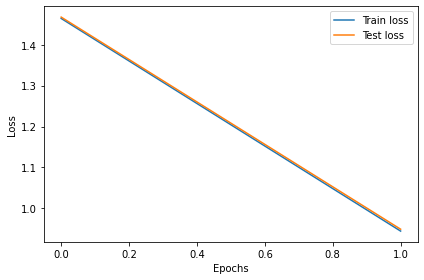

In [10]:
def train(args, model, data, rng):
    model_checkpoint = root_path + args.loss + "_rigid_params.pkl"

    best_params = None
    best_loss = np.inf
    best_small_loss = np.inf
    (nn_forward_fn, init_params) = model
    data = {k: jax.device_put(v) for k,v in data.items()}

    loss = make_loss(args)
    opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t  < args.num_epochs//2,
                          t >= args.num_epochs//2],
                         [args.lr, args.lr2]))
    opt_state = opt_init(init_params)

    @jax.jit
    def update_derivative(i, opt_state, batch, l2reg):
        params = get_params(opt_state)
        return opt_update(i, jax.grad(loss, 0)(params, batch, l2reg), opt_state), params

    train_losses, test_losses = [], []

    print("####################################### Train start #######################################")
    for iteration in range(args.num_epochs):
        rand_idx = jax.random.randint(rng, (args.batch_size,), 0, len(data['x']))
        rng += 1

        batch = (data['x'][rand_idx], data['dx'][rand_idx])
        opt_state, params = update_derivative(iteration, opt_state, batch, args.l2reg)
        small_loss = loss(params, batch, 0.0)

        new_small_loss = False
        if small_loss < best_small_loss:
            best_small_loss = small_loss
            new_small_loss = True

        if new_small_loss or (iteration % 1000 == 0) or (iteration < 1000 and iteration % 100 == 0):
          params = get_params(opt_state)
          train_loss = loss(params, (data['x'], data['dx']), 0.0)/len(data['x'])
          train_losses.append(train_loss)
          test_loss = loss(params, (data['test_x'], data['test_dx']), 0.0)/len(data['test_x'])
          test_losses.append(test_loss)

          if test_loss < best_loss:
              best_loss = test_loss
              best_params = params

          if jnp.isnan(test_loss).sum():
              break

          print(f"-------> New best loss! Train_loss={train_loss:.6f}, Test_loss={test_loss:.6f}")
        print(f"Epoch: {iteration}/{args.num_epochs}")

    params = get_params(opt_state)
    write_to({'params': best_params, 'args': args},model_checkpoint)
    print("####################################### Train end #######################################")
    print("--- Best loss: ", best_loss)
    
    return params, train_losses, test_losses

print('Globals:', args.__dict__)
rng = jax.random.PRNGKey(0)
init_random_params, nn_forward_fn = extended_mlp(args)
_, init_params = init_random_params(rng+1, (-1, 2)) #4
model = (nn_forward_fn, init_params)
data = new_get_dataset(jax.random.PRNGKey(0), t_span=[0, args.dataset_size], fps=args.fps, samples=args.samples, test_split=0.7)
result = train(args, model, data, rng+3)
plot_loss(result[1],result[2])